<a href="https://colab.research.google.com/github/madelineadee/CSS_Project1_Team1_Spring2023/blob/main/CSS_Project_5_Maddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

## Setup

In [3]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
import spacy
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# need to install newer version
#!pip install 'gensim>=4.0.0'

# gensim
import gensim
from gensim import models
from gensim.models import KeyedVectors 
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
# authenticate google drive and download data file for assignment
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1v5zATDs2Kud_k2Volcjg4fniA4_zslXx' 

download = drive.CreateFile({'id': file_id})

# Download the file to a local disc
download.GetContentFile('data.csv')
congress_tweets  = pd.read_csv("data.csv")
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [ ]:
congress_tweets.shape

(946791, 16)

In [5]:
# create sample so code won't take so long to run

# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets_sample = congress_tweets.sample(n = 5000)


In [6]:
congress_tweets_sample = congress_tweets_sample.loc[(congress_tweets['party'] == 'Democrat') | (congress_tweets['party'] =='Republican')]

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [7]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    
    # remove indicators for retweet, quote tweet, and ampersand
    # and a few letters that are showing up on their own
    nlp.Defaults.stop_words |= {"RT", "QT","AMP", "amp", "s", "m", "nt"}

    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [8]:
congress_tweets_sample['tokens'] = congress_tweets_sample['text'].map(lambda x: rem_punc_stop(x))
congress_tweets_sample['tokens']

324329    [ICYMI, I, joined, Gary, Chamber, Commerce, di...
104538    [devex, Do, miss, AdvaSals, oneonone, intervie...
367972    [🚨, DEMOCRAT, HYPOCRISY, 🚨, \n\n, They, shut, ...
558147    [Thank, HeyNowJO, worked, hard, reality, HeyNo...
24561     [Just, minutes, ago, Vice, Chairwoman, Judicia...
                                ...                        
708199    [RepLoriTrahan, If, pay, 750, year, taxes, pay...
246515    [HillsboroughSOE, Early, Voting, underway, Hil...
264842    [The, Open, Courts, Act, meaningful, differenc...
664856    [RepLucyMcBath, Had, great, time, cheering, co...
303305    [RSVP, tonight, ClimateAction,   , TeleTown, H...
Name: tokens, Length: 4982, dtype: object

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: Word cloud

Below are word clouds for all sampled tweets, and then word clouds split by party or position. 




**Word cloud for all 5,000 sampled tweets regardless of position or party.**

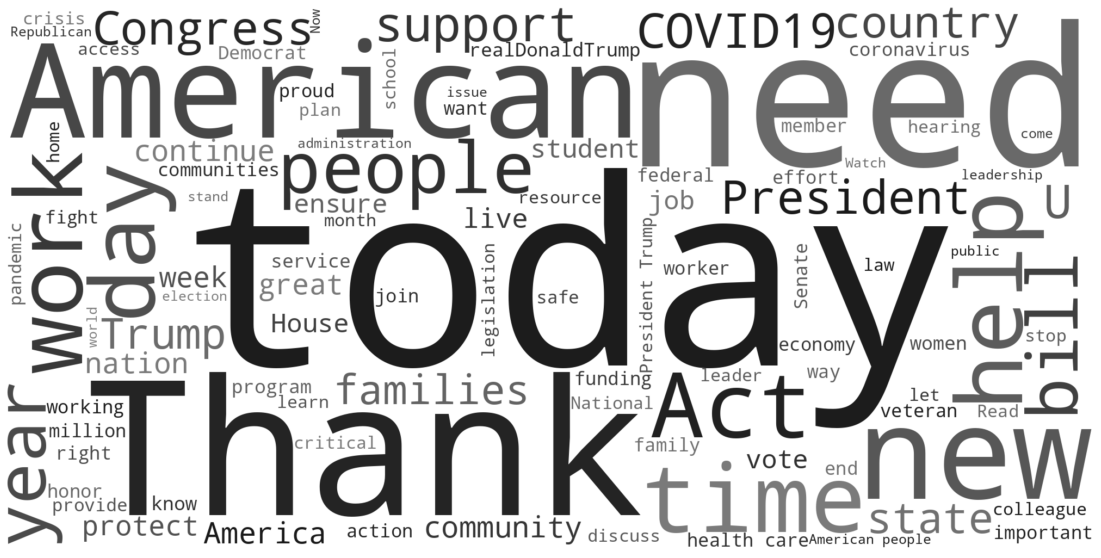

In [ ]:
# change the value in return to set the single color need, in hsl format.
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(172,0%%, %d%%)" % numpy.random.randint(10,50))

text = ' '.join(congress_tweets_sample['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud(background_color = "white", width=2000, height=1000, max_words = 100).generate(text)
#change the text color setting
wordcloud.recolor(color_func = grey_color_func)
plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

plt.show()

# notes for modifying word clouds
#https://stackoverflow.com/questions/28786534/increase-resolution-with-word-cloud-and-remove-empty-border
#https://www.datacamp.com/tutorial/wordcloud-python

In [ ]:
# get the unique values for position
pd.unique(congress_tweets_sample[['position']].values.ravel())


array(['Sen', 'Rep'], dtype=object)

In [ ]:
pos_rep_tweets = congress_tweets_sample[congress_tweets_sample.position=='Rep']
pos_sen_tweets = congress_tweets_sample[congress_tweets_sample.position=='Sen']

**Word-cloud for Representatives**

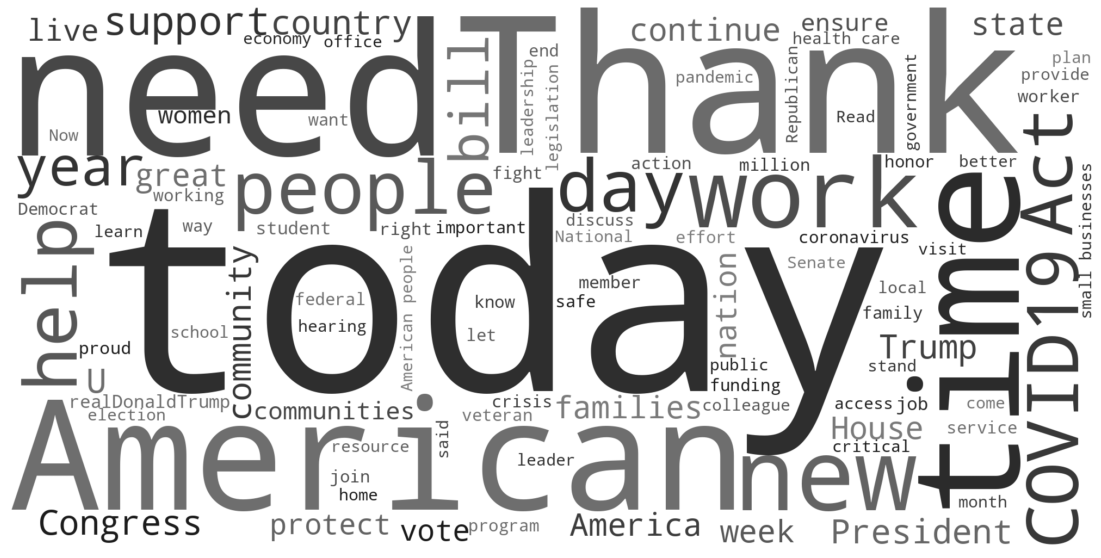

In [ ]:
text = ' '.join(pos_rep_tweets['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud(background_color = "white", width=2000, height=1000, max_words = 100).generate(text)
#change the text color setting
wordcloud.recolor(color_func = grey_color_func)
plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

plt.show()

**Word-cloud for Senators**

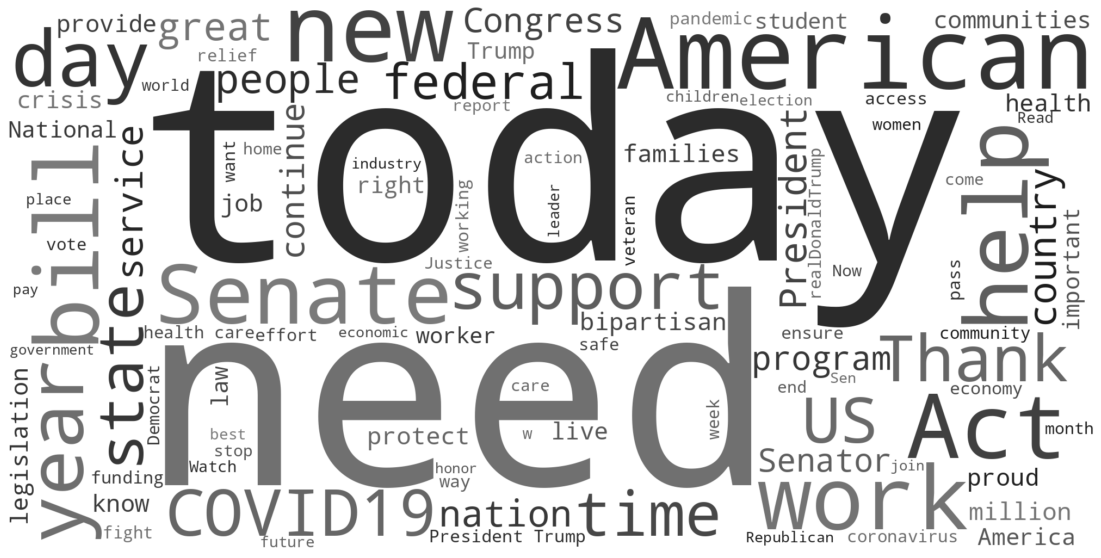

In [ ]:
text = ' '.join(pos_sen_tweets['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud(background_color = "white", width=2000, height=1000, max_words = 100).generate(text)
#change the text color setting
wordcloud.recolor(color_func = grey_color_func)
plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

plt.show()

In [ ]:
# get the unique values for party
pd.unique(congress_tweets_sample[['party']].values.ravel())

array(['Democrat', 'Republican', 'Independent'], dtype=object)

In [ ]:
party_rep_tweets = congress_tweets_sample[congress_tweets_sample.party=='Republican']
party_dem_tweets = congress_tweets_sample[congress_tweets_sample.party=='Democrat']

**Word-cloud for Republicans**

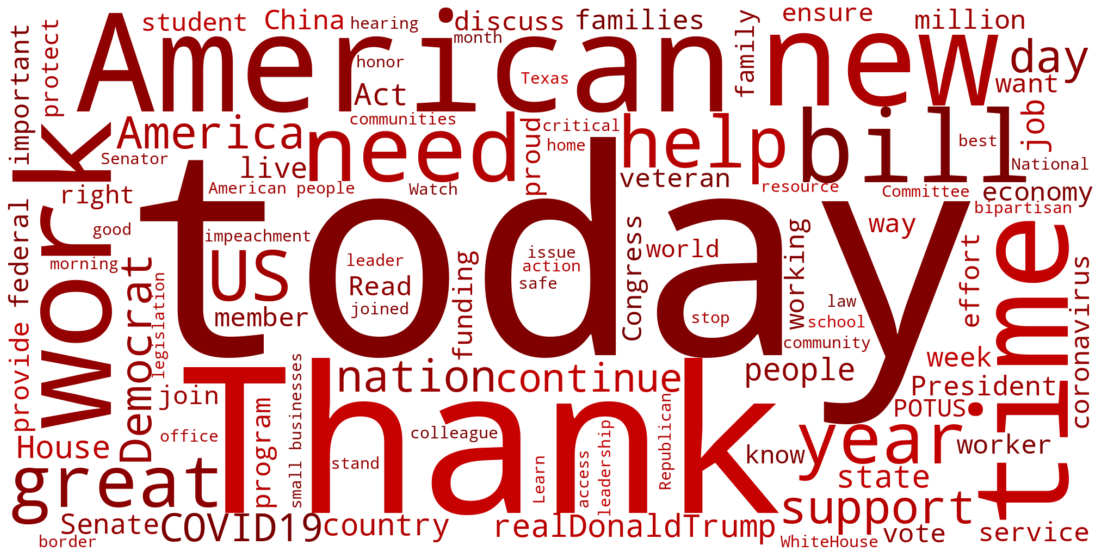

In [ ]:
#change the value in return to set the single color need, in hsl format.
def red_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%%, %d%%)" % numpy.random.randint(24,40))

text = ' '.join(party_rep_tweets['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud(background_color = "white", width=2000, height=1000, max_words = 100).generate(text)
#change the text color setting
wordcloud.recolor(color_func = red_color_func)
plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

plt.show()

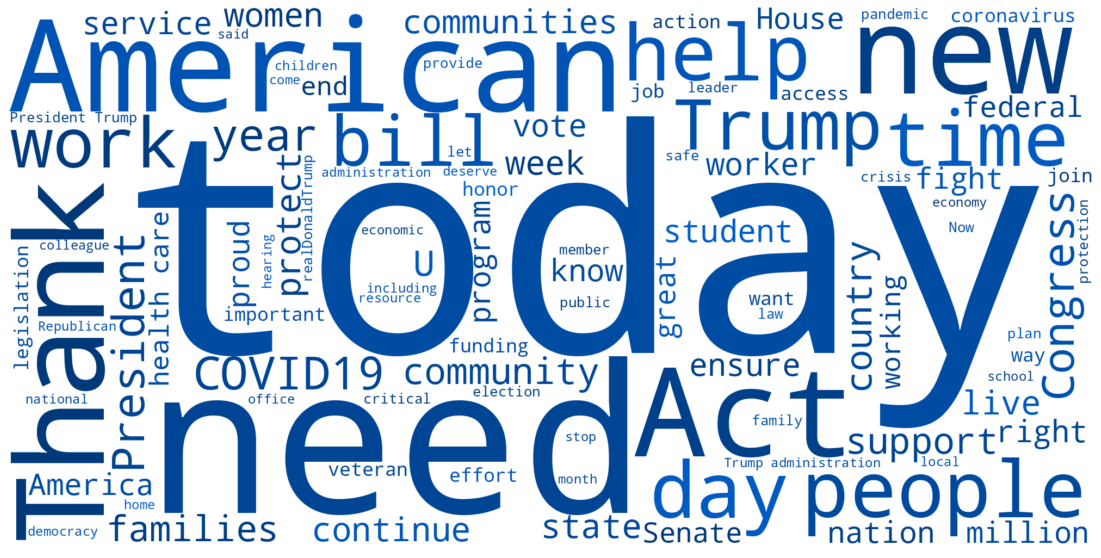

In [ ]:
#change the value in return to set the single color need, in hsl format.
def blue_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(212,100%%, %d%%)" % numpy.random.randint(24,40))

text = ' '.join(party_dem_tweets['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud(background_color = "white", width=2000, height=1000, max_words = 100).generate(text)
#change the text color setting
wordcloud.recolor(color_func = blue_color_func)
plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

plt.show()

### EDA 2: N-grams

In [9]:
congress_tweets_sample['tokens'] = congress_tweets_sample['tokens'].map(lambda text: ' '.join(text))

In [10]:
# convert to a list for it to work in this function
sw = list(STOP_WORDS)

countvec = CountVectorizer(stop_words=sw, ngram_range=(2,3))
ngrams = countvec.fit_transform(congress_tweets_sample['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names_out())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head()


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'qt', 'rt', 've'] not in stop_words.
  warnings.warn(


,ngrams,freq
0,health care,144
1,president trump,108
2,small businesses,94
3,american people,84
4,trump administration,60


**Top 25 N-grams (all 5,000 sampled tweets)**

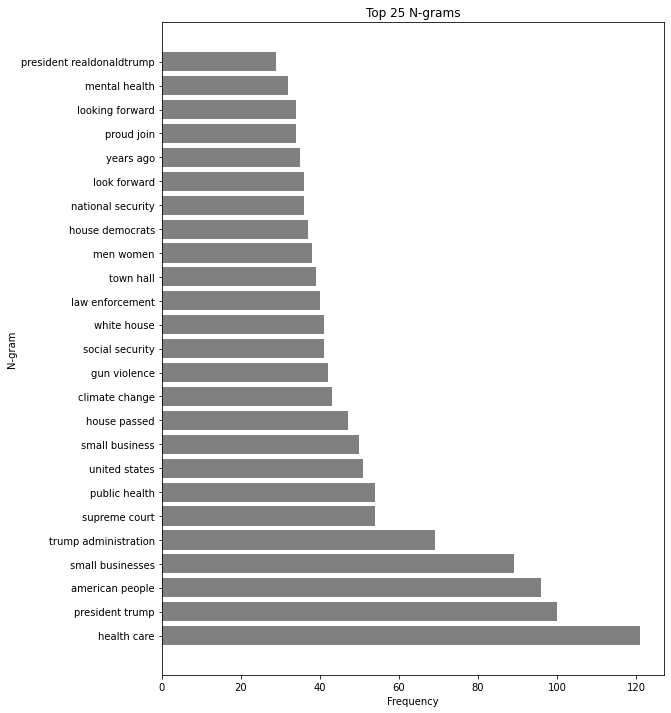

In [ ]:
#sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
#plt.xticks(rotation=90)
#plt.show()

plot_data = df_ngram[0:25]

height = plot_data['freq']
bars = plot_data['ngrams']
y_pos = numpy.arange(len(bars))

plt.figure( figsize=(9,12))
# Basic plot
plt.barh(y_pos, height, color ='grey')
 
# use the plt.xticks function to custom labels
plt.yticks(y_pos, bars, horizontalalignment='right')
plt.title('Top 25 N-grams')
plt.ylabel('N-gram')
plt.xlabel('Frequency')

plt.show()


In [ ]:
# Non-text features
non_text_features = congress_tweets_sample[['position', 
                                            'party']]

# Top 300 ngrams + non-text
top_300_ngrams = df_ngram[0:300]
non_text_with_ngrams = non_text_features.reset_index(drop = True).join(top_300_ngrams)

,position,party,ngrams,freq
0,Sen,Democrat,health care,121.0
1,Sen,Republican,president trump,100.0
2,Rep,Democrat,american people,96.0
3,Rep,Democrat,small businesses,89.0
4,Rep,Democrat,trump administration,69.0


**Top 25 N-grams (sampled Representatives)**

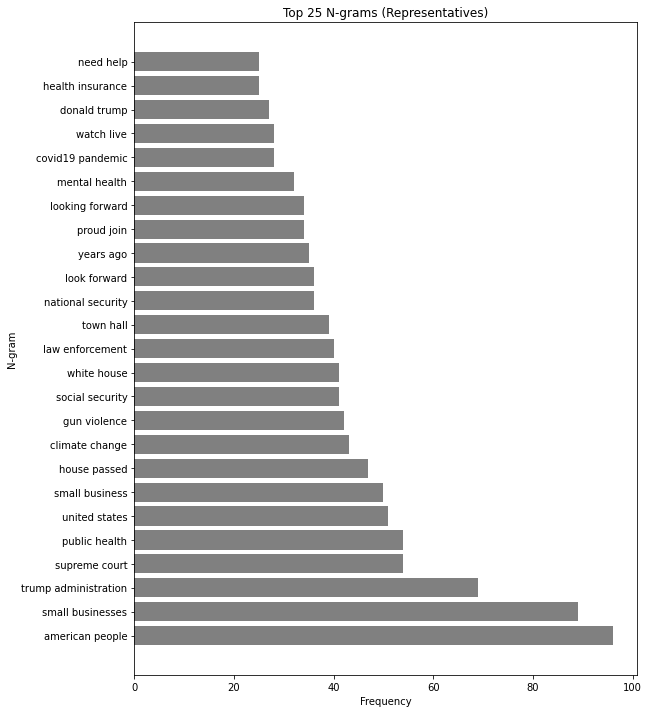

In [ ]:
plot_data = non_text_with_ngrams[non_text_with_ngrams.position=='Rep']
plot_data = plot_data.nlargest(25,'freq')


height = plot_data['freq']
bars = plot_data['ngrams']
y_pos = numpy.arange(len(bars))

plt.figure( figsize=(9,12))
# Basic plot
plt.barh(y_pos, height, color ='grey')
 
# use the plt.xticks function to custom labels
plt.yticks(y_pos, bars, horizontalalignment='right')
plt.title('Top 25 N-grams (Representatives)')
plt.ylabel('N-gram')
plt.xlabel('Frequency')

plt.show()


**Top 25 N-grams (sampled Senators)**



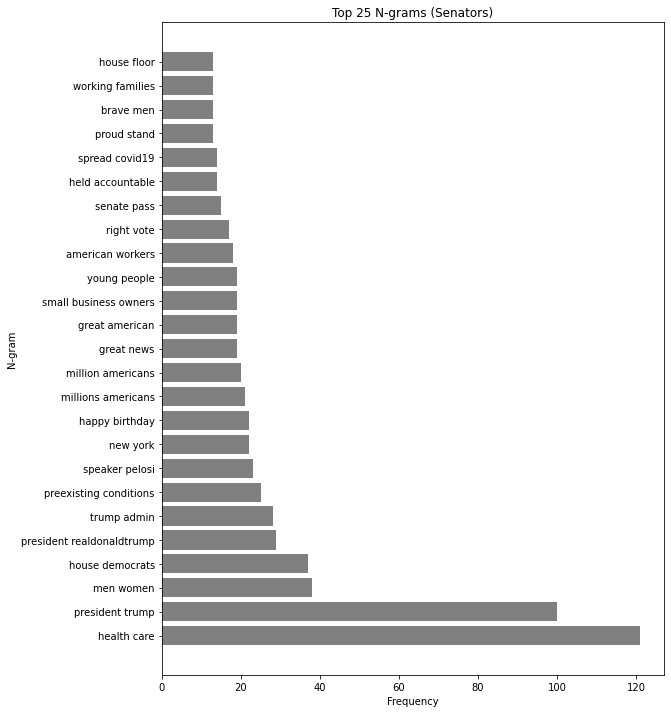

In [ ]:
plot_data = non_text_with_ngrams[non_text_with_ngrams.position=='Sen']
plot_data = plot_data.nlargest(25,'freq')


height = plot_data['freq']
bars = plot_data['ngrams']
y_pos = numpy.arange(len(bars))

plt.figure( figsize=(9,12))
# Basic plot
plt.barh(y_pos, height, color ='grey')
 
# use the plt.xticks function to custom labels
plt.yticks(y_pos, bars, horizontalalignment='right')
plt.title('Top 25 N-grams (Senators)')
plt.ylabel('N-gram')
plt.xlabel('Frequency')

plt.show()

**Top 25 N-grams (sampled Republicans)**

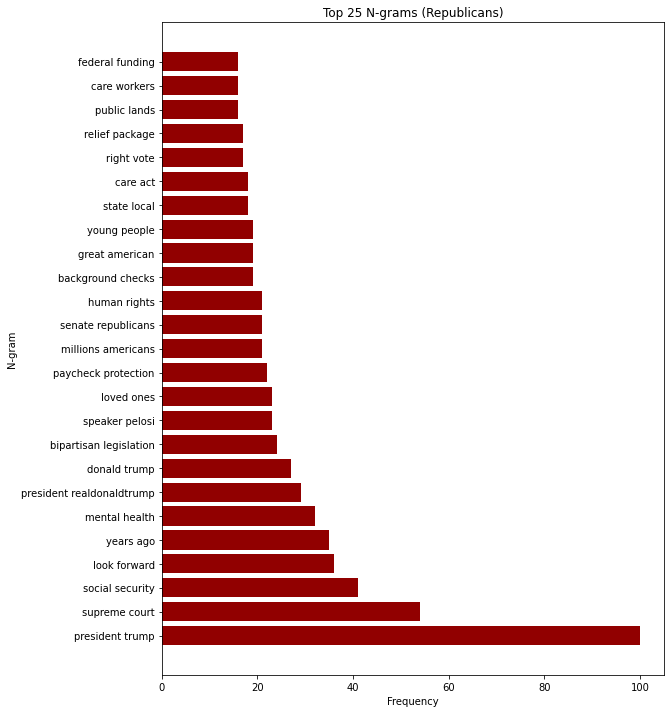

In [ ]:
plot_data = non_text_with_ngrams[non_text_with_ngrams.party=='Republican']
plot_data = plot_data.nlargest(25,'freq')


height = plot_data['freq']
bars = plot_data['ngrams']
y_pos = numpy.arange(len(bars))

plt.figure( figsize=(9,12))
# Basic plot
plt.barh(y_pos, height, color ='#910000')
 
# use the plt.xticks function to custom labels
plt.yticks(y_pos, bars, horizontalalignment='right')
plt.title('Top 25 N-grams (Republicans)')
plt.ylabel('N-gram')
plt.xlabel('Frequency')

plt.show()

**Top 25 N-grams (sampled Democrats)**

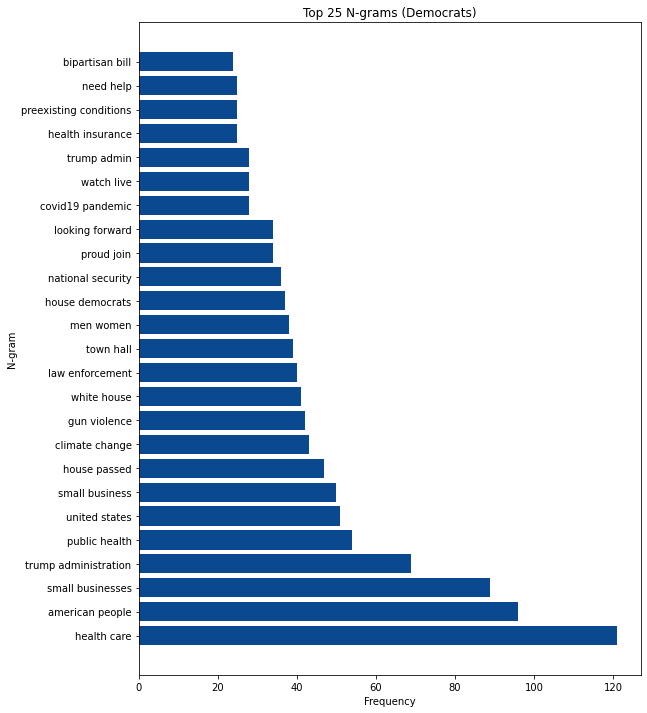

In [ ]:
plot_data = non_text_with_ngrams[non_text_with_ngrams.party=='Democrat']
plot_data = plot_data.nlargest(25,'freq')


height = plot_data['freq']
bars = plot_data['ngrams']
y_pos = numpy.arange(len(bars))

plt.figure( figsize=(9,12))
# Basic plot
plt.barh(y_pos, height, color ='#0A4990')
 
# use the plt.xticks function to custom labels
plt.yticks(y_pos, bars, horizontalalignment='right')
plt.title('Top 25 N-grams (Democrats)')
plt.ylabel('N-gram')
plt.xlabel('Frequency')

plt.show()

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [ ]:
# name of senators and representatives in the sample
pd.unique(congress_tweets_sample[['name_wikipedia']].values.ravel())


array(['Jeff Merkley', 'John Cornyn', 'Rashida Tlaib', 'Linda Sánchez',
       'Hank Johnson', 'Drew Ferguson', 'Joe Courtney', 'Deb Haaland',
       'John B. Larson', 'Susan Wild', 'Ayanna Pressley', 'Al Lawson',
       'Chuck Fleischmann', 'Kathleen Rice', 'Val Demings', 'Lori Trahan',
       'Joe Manchin', 'Bob Casey Jr.', 'Donald Norcross', 'Garret Graves',
       'Mike Gallagher', 'Stephanie Murphy', 'Mike Thompson',
       'Kevin Hern', 'Deb Fischer', 'Kathy Castor', 'Carolyn Maloney',
       'Jeanne Shaheen', 'Andy Biggs', 'Joaquín Castro', 'Chuck Schumer',
       'Brian Higgins', 'John Katko', 'Barbara Lee', 'Madeleine Dean',
       'Steven Horsford', 'John Garamendi', 'Marsha Blackburn',
       'Nydia Velázquez', 'Sheldon Whitehouse', 'Jared Huffman',
       'Dianne Feinstein', 'Ralph Norman', 'Roy Blunt', 'Jim Costa',
       'Elaine Luria', 'Steven Palazzo', 'Chip Roy', 'Patty Murray',
       'Antonio Delgado', 'Filemon Vela Jr.', 'Jesús García',
       'John Sarbanes', 'Will

**Subjectivity and Polarity for Alexandria Ocasio-Cortez (more liberal) and Ted Cruz (more conservative)**




In [ ]:
# Many of these people that I was choosing didn't have many tweets in the subsample of data, 
# so created a dataframe off all of their tweets and sampled 100 tweets from each
df_subset = congress_tweets.loc[(congress_tweets['name_wikipedia'] == 'Alexandria Ocasio-Cortez') | (congress_tweets['name_wikipedia'] =='Ted Cruz')]
df_subset.shape

(7003, 16)

In [ ]:
df_subset_sample = df_subset.groupby("name_wikipedia").apply(lambda x: x.sample(200)).reset_index(drop=True)

In [ ]:
# re-run sentiment and polarity on this sample
df_subset_sample['tokens'] = df_subset_sample['text'].map(lambda x: rem_punc_stop(x))
df_subset_sample['tokens'] = df_subset_sample['tokens'].map(lambda text: ' '.join(text))
df_subset_sample['polarity'] = df_subset_sample['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
df_subset_sample['subjectivity'] = df_subset_sample['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

In [ ]:
df_liberal = df_subset_sample.loc[df_subset_sample['name_wikipedia'] == 'Alexandria Ocasio-Cortez'] 
df_conservative = df_subset_sample.loc[df_subset_sample['name_wikipedia'] == 'Ted Cruz'] 

#df_liberal.shape
#df_conservative.shape

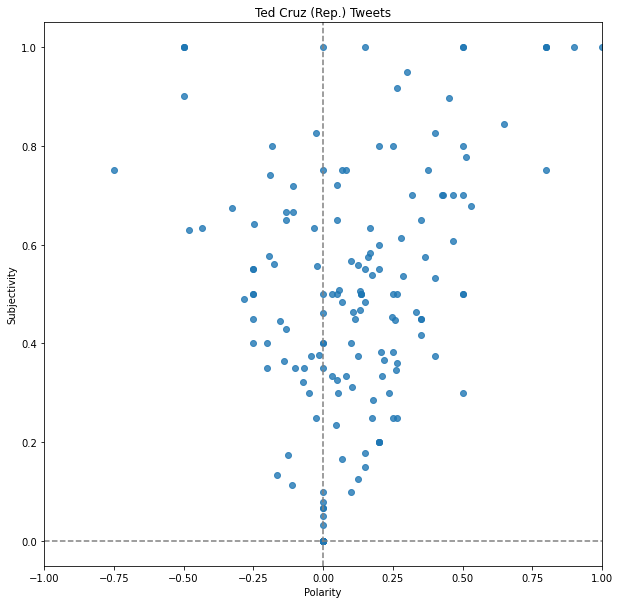

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = df_conservative['polarity']
y = df_conservative['subjectivity']

plt.figure(figsize=(10,10))
plt.scatter(x, y, alpha=0.8)
plt.title("Ted Cruz (Rep.) Tweets")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.axhline(y=0, color='grey', linestyle='--')
plt.axvline(x=0, color='grey', linestyle='--')


plt.xlim(-1, 1)

plt.show()

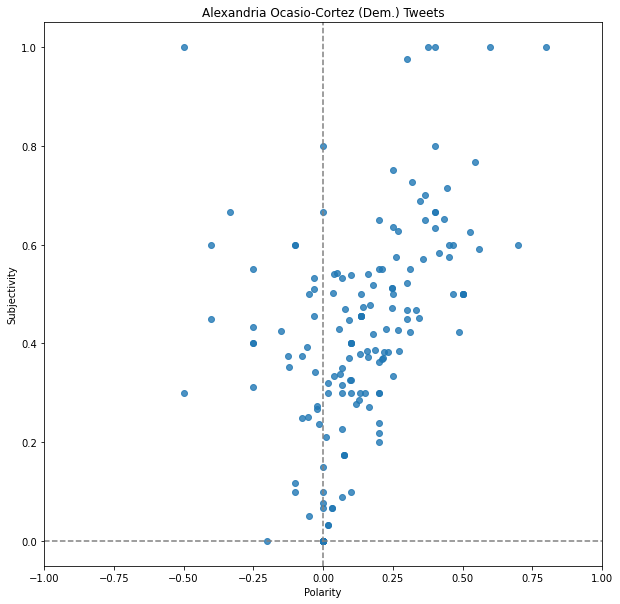

In [ ]:
x = df_liberal['polarity']
y = df_liberal['subjectivity']

plt.figure(figsize=(10,10))
plt.scatter(x, y, alpha=0.8)
plt.title("Alexandria Ocasio-Cortez (Dem.) Tweets")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.axhline(y=0, color='grey', linestyle='--')
plt.axvline(x=0, color='grey', linestyle='--')


plt.xlim(-1, 1)
#plt.ylim(-1, 1)

plt.show()

The two scatter plots above show subjectivity vs. polarity for Ted Cruz and Alexandria Ocasio-Cortez. Polarity ranges from -1 (negative sentiment) to 1 (positive sentiment) and is shown on the x-axis. Both people have tweets on of both negative and positive sentiment here, with a bit higher frequency of positive sentiment for both. 

Subjectivity is shown on the Y axis and ranges from 0 (factual information) to 1 (personal opinion). Both people show tweets throughout this range, although I would guess the average subjectivity for Ocasio-Cortez is a bit lower than the average for Cruz based on these plots. 

Overall, I am surprised that both show a relatively similar pattern though. Interestingly, both show a v shape that indicated when tweets contain more factual information, they are less likely to show strong polarity, and when tweets have more personal opion they are likely to have stronger polarity (which makes sense but is interesting to see in the data!). 

**NOTE: Plots showing visualizations split by party and position are shown above with the exploratory data analysis.**
  


## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [11]:
# Engineered Features
congress_tweets_sample['polarity'] = congress_tweets_sample['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets_sample['subjectivity'] = congress_tweets_sample['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
congress_tweets_sample['word_count'] = congress_tweets_sample['text'].apply(lambda x: len(str(x).split()))
congress_tweets_sample['length'] = congress_tweets_sample['text'].apply(len)

congress_tweets_sample.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,polarity,subjectivity,word_count,length
324329,1.272600e+18,SenToddYoung,2020-06-15T14:30:00-04:00,#ICYMI: I joined the Gary Chamber of Commerce ...,Todd Young,Sen,3-Jan-19,8/24/1972,M,IN,...,Republican,"1,557,286","1,033,126","1,152,887","1,420,543",ICYMI I joined Gary Chamber Commerce discuss a...,-0.125000,0.233333,31,352
104538,1.216110e+18,RepBera,2020-01-11T16:46:24-05:00,RT @devex Don't miss @AdvaSal's one-on-one int...,Ami Bera,Rep,3-Jan-13,3/2/1965,M,CA,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",devex Do miss AdvaSals oneonone interview Wash...,0.136364,0.454545,33,276
367972,1.334140e+18,SteveScalise,2020-12-02T09:05:10-05:00,🚨 DEMOCRAT HYPOCRISY 🚨\n\nThey shut down your ...,Steve Scalise,Rep,3-May-08,10/6/1965,M,LA,...,Republican,"1,178,638","780,154","809,141","1,152,262",🚨 DEMOCRAT HYPOCRISY 🚨 \n\n They shut business...,0.000000,0.000000,36,352
558147,1.119310e+18,RepMaxRose,2019-04-19T14:35:12-04:00,Thank you @HeyNowJO and all those who worked s...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,...,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",Thank HeyNowJO worked hard reality HeyNowJO Fr...,0.205556,0.798611,61,447
24561,1.204170e+18,RepAndyBiggsAZ,2019-12-09T17:38:50-05:00,"Just a few minutes ago, the Vice Chairwoman of...",Andy Biggs,Rep,3-Jan-17,11/7/1958,M,AZ,...,Republican,"1,252,401","1,161,167","1,025,232","1,233,654",Just minutes ago Vice Chairwoman Judiciary Com...,0.200000,1.000000,45,278


In [12]:
# data frame of engineered features
engineered_features = congress_tweets_sample[['polarity', 'subjectivity', 'word_count', 'length']].reset_index(drop = True)

### Bag-of-words or Tf-idf

In [13]:
# Non-text features
non_text_features = congress_tweets_sample[['position', 
                                            'party',
                                            'birthday',
                                            'gender',
                                            'state',
                                            'trump_2016_state_share', 
                                            'clinton_2016_state_share', 
                                            'obama_2012_state_share', 
                                            'romney_2012_state_share']]

non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)



In [14]:
# Top 50 ngrams + non-text
top_50_ngrams = df_ngram[0:50]
non_text_with_ngrams_5000 = non_text_features_dummies.reset_index(drop = True).join(top_50_ngrams)

### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [23]:
# need tokens back in this format
congress_tweets_sample['tokens'] = congress_tweets_sample['text'].map(lambda x: rem_punc_stop(x))

In [24]:
model = gensim.models.Word2Vec(congress_tweets_sample['tokens'], min_count=5, vector_size = 100, window=5, 
                               sg=0, alpha=0.025, epochs = 5, batch_words=10000)

In [87]:
words = list(model.wv.index_to_key)
print(len(model.wv.index_to_key))
print(words[0:100])

3973
['\n\n', 'I', '\n', 'The', 'We', ' ', 'This', 'Trump', 'people', 'work', 'House', 'COVID19', 'It', 'President', 'need', 'Act', 'help', 'today', 'Americans', 'American', 'health', 'bill', 'Congress', '”', '“', 'time', 'Today', '—', 'support', 'Senate', 'country', 'US', 'care', 'families', 'Thank', 'new', 'communities', 'working', 'America', 'continue', 'community', 'workers', 'crisis', 'like', 'protect', 'vote', 'years', 'realDonaldTrump', '️', '\n \n', 'federal', 'lives', 'proud', 'bipartisan', 'As', 'public', '–', 'week', 'pandemic', 'women', 'If', 'day', 'businesses', 'Democrats', 'right', 'state', 'great', 'In', 'My', 'know', 'legislation', 'important', 'year', 'ensure', 'access', 'funding', 'nation', 'passed', 'Our', 'students', 'law', 'fight', 'home', 'government', 'service', 'coronavirus', 'That', 'hearing', 'colleagues', 'local', 'small', 'economy', 'safe', 'A', 'jobs', 'pass', 'Republicans', 'way', 'honor', 'relief']


In [93]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(self, word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return numpy.mean(model[doc], axis=0)

In [94]:
# can't get this part to work
congress_tweets_sample['w2v_mean'] = congress_tweets_sample['text'].apply(document_vector, args = (model, congress_tweets_sample['text']))

TypeError: ignored

In [31]:
# embedding based featurization
X = model.wv.__getitem__(model.wv.index_to_key)

# make a PCA
pca = PCA(n_components=2) #set n_components to 2 to graph in 2-D

In [32]:
# standardize data
X_std = StandardScaler().fit_transform(X)

# fit the standardized data
Y_pca = pca.fit_transform(X_std)

<AxesSubplot:>

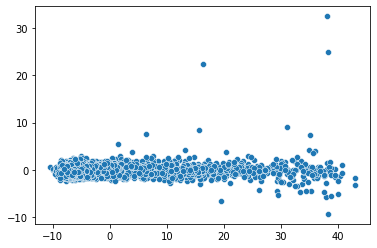

In [33]:
sns.scatterplot(x = Y_pca[:, 0], y = Y_pca[:, 1])

I tried to improve on this standard figure some, but this still needs some work due to all the overlap.

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 128071 (\N{WHITE DOWN POINTING BACKHAND INDEX}) missing from current font.
  fig.canvas.print_figure(by

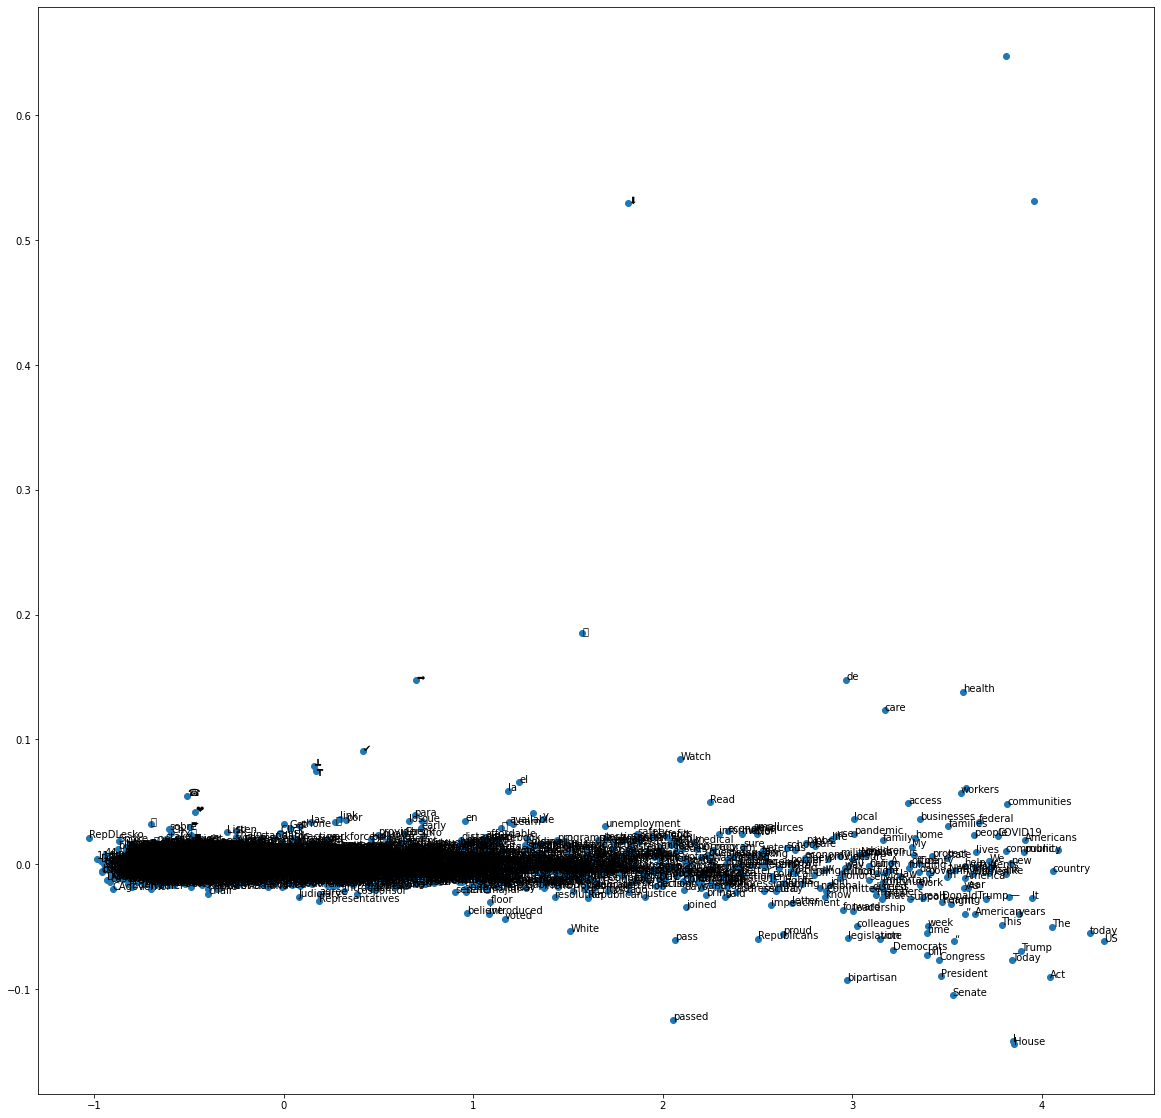

In [42]:
X = model.wv.__getitem__(model.wv.index_to_key)
# make a PCA
pca = PCA(n_components=2) #set n_components to 2 to graph in 2-D

result = pca.fit_transform(X)

# create a scatter plot of the projection
plt.figure(figsize=(20,20))
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.index_to_key)

for i, word in enumerate(words):
   plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show()

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

*Note: only 4 models since I had difficulties making the averaged by document (tweet) word embeddings work. *

In [15]:
dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names_out())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)

top_50_ngrams = dictionary_dataframe.loc[:,df_ngram[0:50]['ngrams']]
top_50_ngrams.head()

,health care,president trump,small businesses,american people,trump administration,united states,public health,law enforcement,gun violence,years ago,...,mental health,hard work,child care,need help,senate republicans,health insurance,american families,prescription drug,continue work,social security
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
engineered_features = congress_tweets_sample[['polarity', 'subjectivity', 'word_count', 'length']].reset_index(drop = True)
engineered_features.head

<bound method NDFrame.head of       polarity  subjectivity  word_count  length
0    -0.125000      0.233333          31     352
1     0.136364      0.454545          33     276
2     0.000000      0.000000          36     352
3     0.205556      0.798611          61     447
4     0.200000      1.000000          45     278
...        ...           ...         ...     ...
4977  0.000000      0.000000          26     204
4978  0.066667      0.366667          43     371
4979  0.100000      0.645000          48     468
4980  0.187500      0.450000          33     316
4981  0.800000      0.900000          39     256

[4982 rows x 4 columns]>

In [17]:
dataframes = [top_50_ngrams, 
              engineered_features]

featurization_technique = ['Top 50 N-Gram Features',
                            'Engineered Features']

lb_style = LabelBinarizer()
y = congress_tweets_sample['position_binary'] = lb_style.fit_transform(congress_tweets_sample['position'])


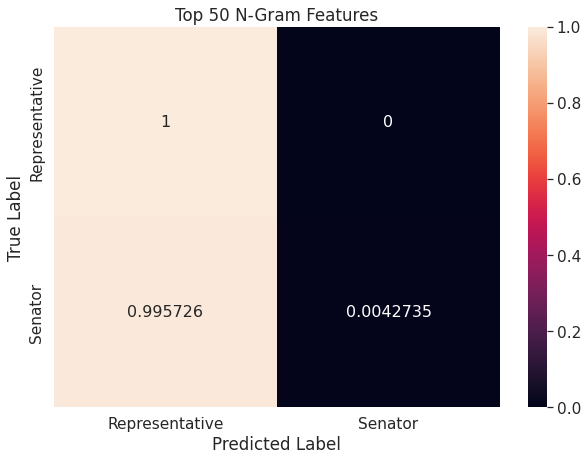

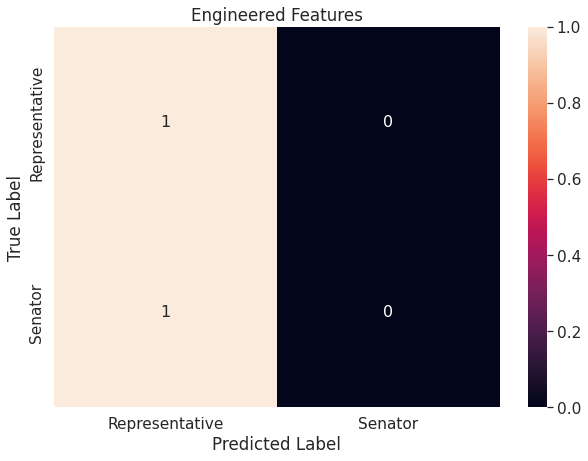

In [18]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
    df_cm.index = ["Representative", "Senator"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [28]:
lb_style = LabelBinarizer()
y = congress_tweets_sample['party_binary'] = lb_style.fit_transform(congress_tweets_sample['party'])

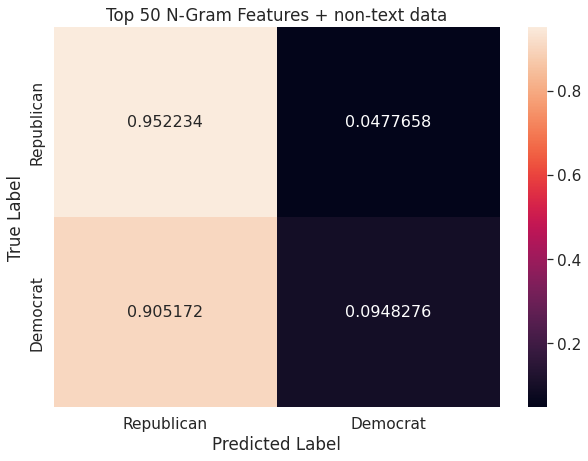

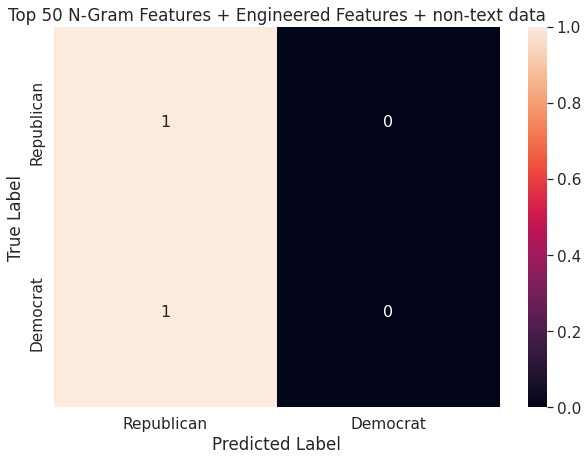

In [29]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
    df_cm.index = ["Republican", "Democrat"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Two Combined Models

In [21]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
non_text_with_ngrams_5000 = non_text_features_dummies.reset_index(drop = True).join(top_50_ngrams)
non_text_with_ngrams_5000_eng = non_text_with_ngrams_5000.reset_index(drop = True).join(engineered_features)

In [22]:
dataframes = [top_50_ngrams, 
              engineered_features]

featurization_technique = ['Top 50 N-Gram Features + non-text data',
                            'Top 50 N-Gram Features + Engineered Features + non-text data']

lb_style = LabelBinarizer()
y = congress_tweets_sample['position_binary'] = lb_style.fit_transform(congress_tweets_sample['position'])

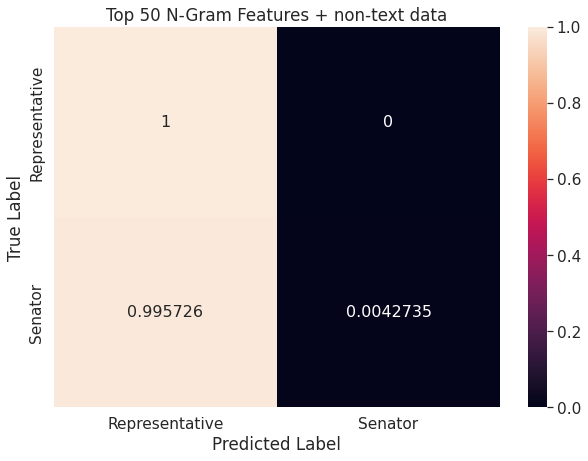

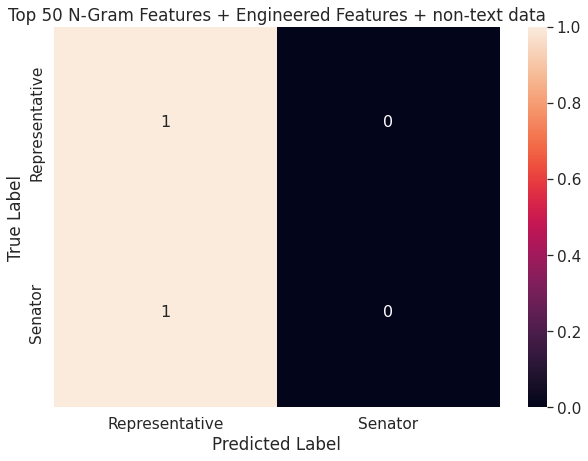

In [24]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
    df_cm.index = ["Representative", "Senator"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [33]:
lb_style = LabelBinarizer()
y = congress_tweets_sample['party_binary'] = lb_style.fit_transform(congress_tweets_sample['party'])


array([[1],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

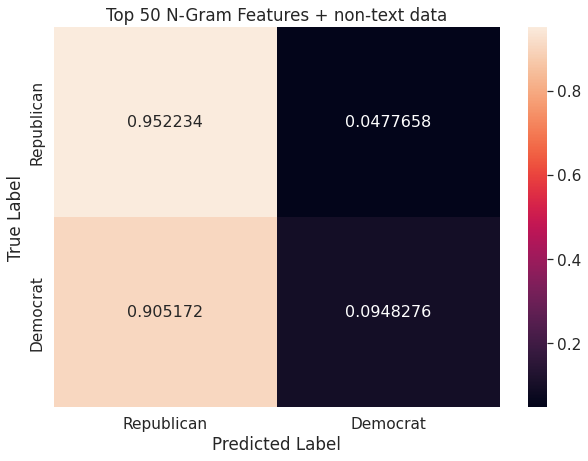

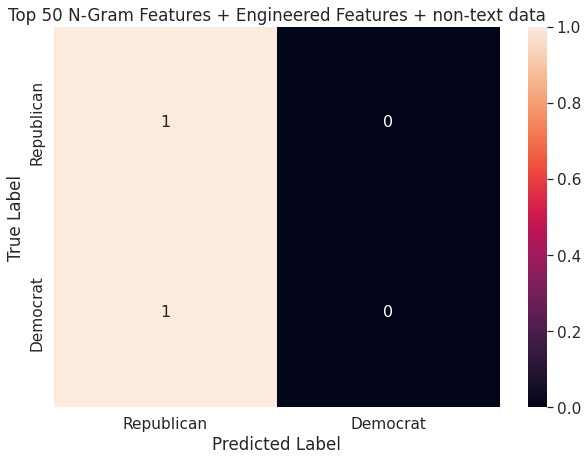

In [32]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
    df_cm.index = ["Republican", "Democrat"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

We can use packages etc. that have some standard pre-processing techniques, but not all of the things we need will be present in these. The pre-processing needed is really dependent on the data. For example with this twitter data, I had to remove tags for retweets and quote tweets when removing stop words and punctuation, because these were the most common "words" in the tweets. Additionally, I had to remove "amp", presumable due to the fact that these were pulled from a website and there was some processing issue with the web code and ampersands. 

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

I thought the best evidence for differences was really coming from the word clouds and n-grams, as the predictive models were not that accurate (It's possible that it's just that I have too small of a sample among certain groups). In the word clouds, you can see that democracts use the words "act", "need", and "people" a lot more and that republicans use the words "time", "work", and "thank" a lot more. In the n-grams analysis, top topics that are different for democrats include "health care", "american people", "small businesses", and "public health". Top topics that are different for republicans include "supreme court", "social security", "look forward", and "years ago". Both parties mentioned "trump administration" a lot.

When comparing positions (represenatitve vs. senator), the differences aren't very noticeable in the word clouds. The major noticeable differences are that the representatives mention "thank" and "time" a lot more. Differences between positions were more noticeable when looking at the n-grams. Top N-grams for senators were "health care" and "president trump" which had a much higher frequency than other n-grams for senators. Top n-grams for representatives were "american people" and "small businesses". 

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

This is important to see how closely these differences are actually related to the groups we are looking at (party and position). Exploratory and unsupervised approches can show us interesting things about the groupings of data (in this case, different text components of tweets) but supervised learning gives us a more in-depth understanding and allows us to see how well we can use the unsupervised learning approches to make predictions. 

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

The best performing model was the top 50 n-grams + non text data. This model did the best at distinguising between groups (although still not well at all), vs. just predicting all tweets belonged to the same group. The intuition behind this is that we can have varied and increased data to train the models, which is likely to make them more accurate at predicting. 

Since the models performed so poorly, in the future I would:
- oversample certain groups such as senators, because I think low numbers of samples in this group in particular may have messed up the models since there are so many more representatives
- choose a different model for predictions
- Use a larger sample size. I limited the analysis to 5,000 tweets (and then removed a few independents because I wasn't sure how to handle them) due to limitations on getting things to run on google colab and time issues. 